# Import libraries

In [1]:
import requests
import glob
import shutil
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Load Data

In [2]:
train_df = pd.read_csv("/kaggle/input/snakeclef2022/SnakeCLEF2022-TrainMetadata.csv")



train_data = train_df[(train_df["code"]=="IN") | (train_df["code"]=="BD") | (train_df["code"]=="BT") |
                      (train_df["code"]=="MV") | (train_df["code"]=="NP") | (train_df["code"]=="PK") |
                      (train_df["code"]=="LK")]

test_data_all = train_data[(train_df["binomial_name"]=="Naja naja") | (train_df["binomial_name"]=="Bungarus caeruleus")| (train_df["binomial_name"]=="Daboia russelii")|
                      (train_df["binomial_name"]=="Echis carinatus")]


train_data.shape

train_data['file_path']="/kaggle/input/snakeclef2022/SnakeCLEF2022-medium_size/SnakeCLEF2022-medium_size/"+train_data['file_path']
test_data_all['file_path']="/kaggle/input/snakeclef2022/SnakeCLEF2022-medium_size/SnakeCLEF2022-medium_size/"+test_data_all['file_path']

train_data['binomial_name']=train_data['binomial_name'].apply(str.lower)
test_data=test_data_all.sample(frac =.2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launch

In [3]:
test_data.shape[0]

261

In [4]:
test_data.head()

,observation_id,endemic,binomial_name,country,code,class_id,file_path
120280,28187787,False,Bungarus caeruleus,West Bengal,IN,220,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
12745,35723474,False,Bungarus caeruleus,Khyber Pakhtunkhwa,PK,220,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
228508,83388349,False,Naja naja,Karnataka,IN,985,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
137537,85734281,False,Daboia russelii,Maharashtra,IN,415,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...
185387,61658190,False,Naja naja,Maharashtra,IN,985,/kaggle/input/snakeclef2022/SnakeCLEF2022-medi...


# Creating Folders

In [5]:
z=['naja naja','bungarus caeruleus','daboia russelii','echis carinatus']
base_path='/kaggle/working/train/'
os.makedirs(base_path)
for i in z:
    k=train_data[(train_data['binomial_name']==i)]
    z=(train_data['binomial_name']==i).sum()
    if z > 20:
        
        os.makedirs(base_path+i+'/')
        for j in k['file_path'] :
            if j.endswith(".jpg") or j.endswith(".jpeg") :
                dst_dir=base_path+i
                img = Image.open(j)
                width, height = img.size
                per=0.2
                xmin=int(width*per)
                xmax=int(width*(1-per))
                ymin=int(height*per)
                ymax=int(height*(1-per))
                crop_img = img.crop((int(xmin) ,int(ymin) ,int(xmax) ,int(ymax)))
                j=os.path.basename(j).split('/')[-1]
                crop_img.save(dst_dir+"//"+j, 'JPEG')


In [6]:
ds = ImageFolder(base_path)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

In [7]:
ds.extensions

('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

# Plotting Sample Images

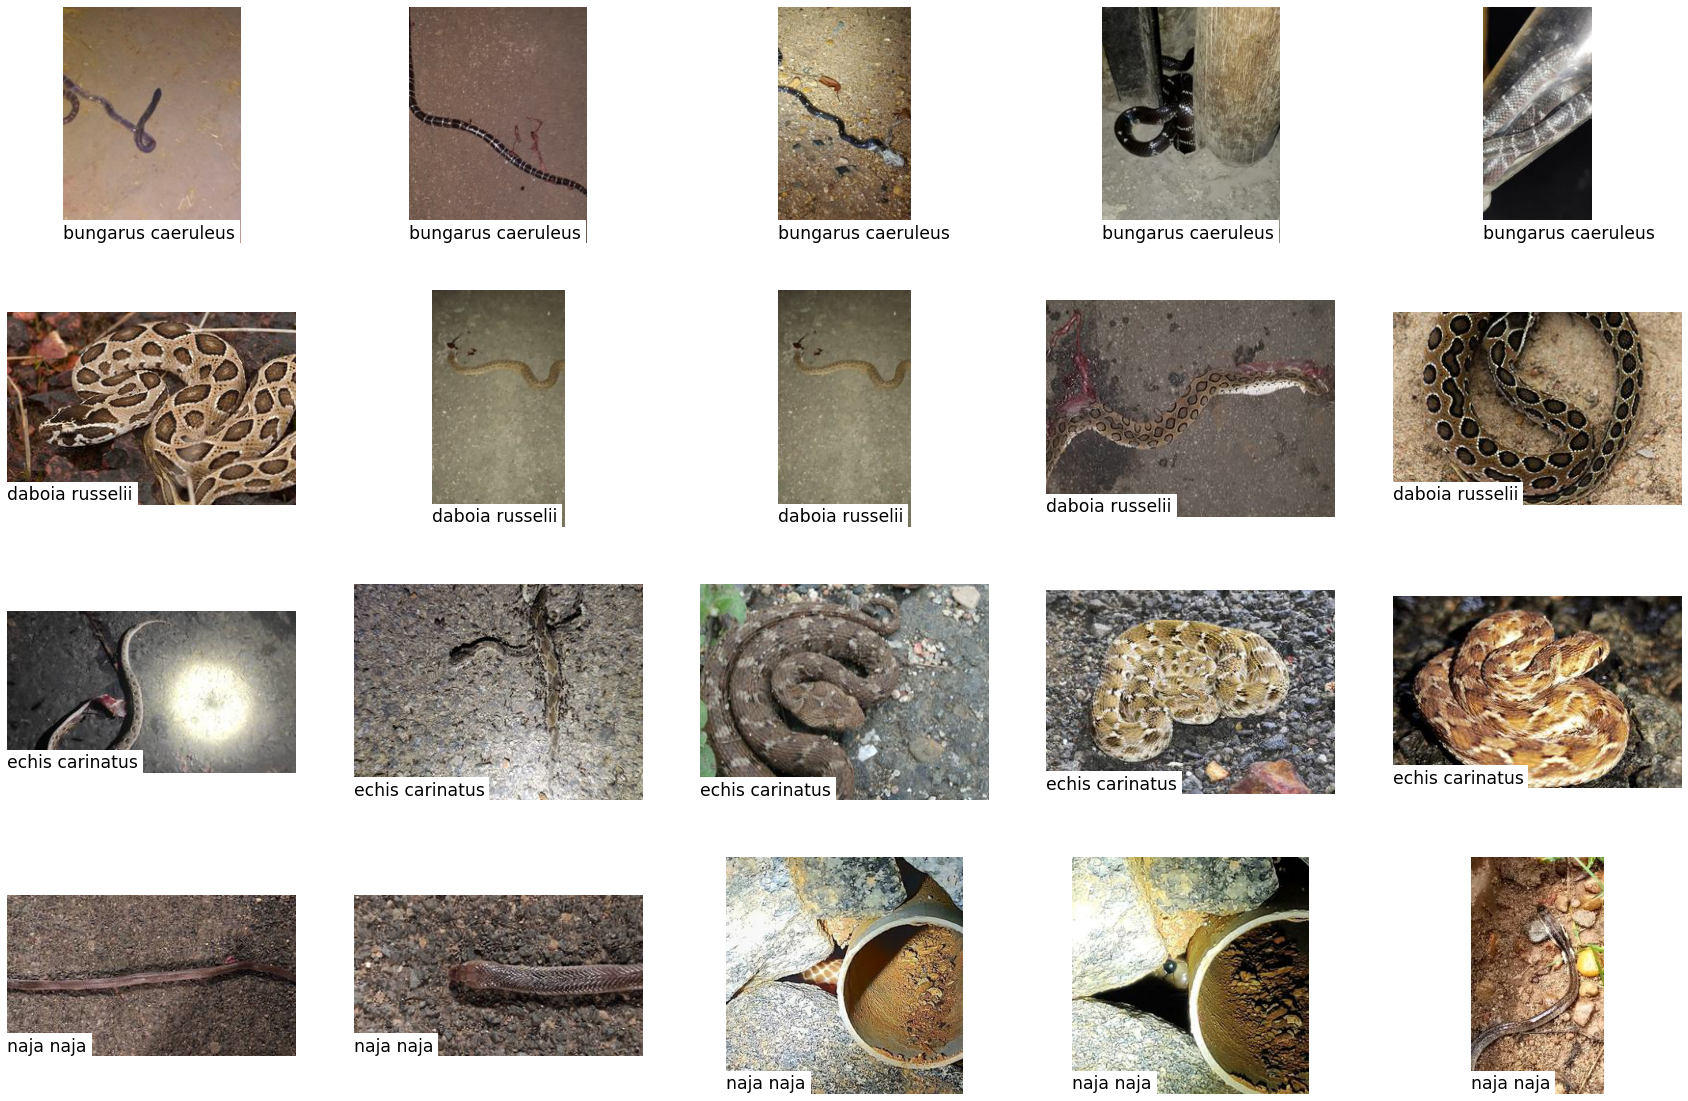

In [8]:
import pathlib
import tensorflow as tf

plt.figure(figsize=(30,20))
num_examples_per_class = 5
i = 1
c=0
for class_idx, class_name in enumerate(ds.classes):
    if c<5:
        c=c+1
    else:
        break
    folder = ds.root+class_name
    folder=pathlib.Path(folder)
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [9]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [10]:
print(id2label)

{'0': 'bungarus caeruleus', '1': 'daboia russelii', '2': 'echis carinatus', '3': 'naja naja'}


# Defining and Loading the base model

In [11]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [12]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Defining util functions

In [13]:
import numpy as np
import torch.nn as nn
import torchmetrics


class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    
        self.train_loss_history = []
        self.val_loss_history = []
        self.val_acc_history = []
        self.val_acc_history_e = []
        #metrics
        self.train_acc = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1Score(number_classes=model.config.num_labels,average="micro")
        self.train_auroc = torchmetrics.AUROC(number_classes=model.config.num_labels,
        average="micro")
        
        self.val_acc = torchmetrics.Accuracy()
        self.val_pre=torchmetrics.AveragePrecision(um_classes=model.config.num_labels,average="macro")
        self.val_f1 = torchmetrics.classification.F1Score(num_classes=model.config.num_labels,average="micro")

        

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        self.train_loss_history.append(outputs.loss.detach().cpu().numpy())
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        self.val_loss_history.append(outputs.loss.detach().cpu().numpy())
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.val_acc_history.append(acc.detach().cpu().numpy())
        return {"loss": outputs.loss, "acc": acc}
        

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    
    
    def validation_epoch_end(self,validation_step_outputs):

        val_accuracy = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        self.log("val_f1", val_f1)
        self.val_acc_history_e.append(val_accuracy.detach().cpu().numpy())
        print(f"\nvalidation accuracy: {val_accuracy:.4} , {val_f1:.4} ,")
        self.val_acc.reset()


    
   

# Training the model

In [14]:
pl.seed_everything(42)
classifier = Classifier(model, lr=1e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=50)
trainer.fit(classifier, train_loader, val_loader)





/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Sanity Checking: 0it [00:00, ?it/s]


validation accuracy: 0.3125 , 0.0 ,


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


validation accuracy: 0.7513 , 0.0 ,


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8912 , 0.0 ,


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.9223 , 0.0 ,


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.9223 , 0.0 ,


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.9223 , 0.0 ,


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [15]:
y=classifier.val_acc_history_e
del y[0]
x=range(1,len(y)+1)

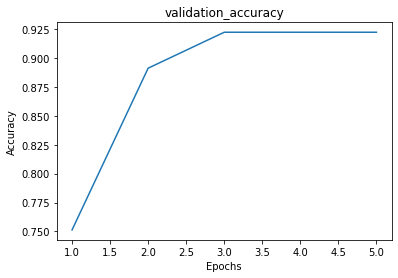

In [16]:
plt.plot(x,y, label="Validation Accuracy")
plt.title("validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [17]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

# Testing

In [ ]:
import torch
import torchvision.transforms as transforms
import transformers
import io


# Preprocess the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


url = 'https://rajasthanbiodiversity.org/wp-content/uploads/2020/11/Russels-Viper-6.jpg'
response = requests.get(url)
image = Image.open(io.BytesIO(response.content))
input_tensor = transform(image).unsqueeze(0)

output = model(input_tensor)



index=output.logits.softmax(1).argmax(1)
print(index)
print(id2label[str(int(index))])


In [ ]:

url = 'https://animalia-bio.us-east-1.linodeobjects.com/animals/photos/full/original/8MSlAJrKOsACgpvKBFGK.webp'
response = requests.get(url)
image = Image.open(io.BytesIO(response.content))
input_tensor = transform(image).unsqueeze(0)

output = model(input_tensor)


print(output)
index=output.logits.softmax(1).argmax(1)
print(index)
print(id2label[str(int(index))])

In [ ]:
total=test_data.shape[0]
correct=0

y_true=[]
y_pred=[]




for index, row in test_data.iterrows():
#     print(index)
    real=row["binomial_name"].lower()
    y_true.append(int(label2id[real]))
    image = Image.open(row["file_path"]).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    output = model(input_tensor)
    index=output.logits.softmax(1).argmax(1)
    y_pred.append(int(index))
    pred=id2label[str(int(index))]
    
    if real==pred :
        correct=correct+1    

# Accuracy Metrics

In [ ]:
from sklearn.metrics import f1_score,precision_score
score = f1_score(y_true,y_pred, average="macro")
print("Macro F1-Score: ", score)

score = f1_score(y_true,y_pred, average="micro")
print("Micro F1-Score: ", score)

score = f1_score(y_true,y_pred, average="weighted")
print("Weighted F1-Score: ", score)



score = precision_score(y_true,y_pred, average="weighted")
print("Precision: ", score)